In [1]:
# Para cargar lo necesario
import pickle

import sys
import os

# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Ahora puedes importar
import customFunctions as cf

#from qiskit.circuit.library import TwoLocal
#from qiskit.circuit import QuantumCircuit

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import QuantumCircuit

def crear_ansatz_nlocal(num_qubits: int, reps: int = 1) -> tuple[QuantumCircuit, int]:
    """
    Crea un ansatz N-local (TwoLocal) con un número dado de qubits y repeticiones.
    Devuelve el circuito y el número de parámetros libres.

    Args:
        num_qubits (int): Número de qubits del circuito.
        reps (int): Número de repeticiones (capas) del ansatz.

    Returns:
        tuple: (QuantumCircuit, número de parámetros del circuito)
    """
    ansatz = TwoLocal(num_qubits,
                      rotation_blocks='ry',
                      entanglement_blocks='cz',
                      entanglement='linear',
                      reps=reps,
                      insert_barriers=True)
    
    return ansatz, ansatz.num_parameters


In [3]:
# 0.719

with open("hamiltonian0.719.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80499838+0.j,  0.17472226+0.j, -0.23347838+0.j,  0.12184887+0.j,
  0.17472226+0.j,  0.16970294+0.j, -0.23347838+0.j,  0.16685625+0.j,
  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,
  0.16685625+0.j,  0.17539742+0.j,  0.12184887+0.j])



Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.08341196576382867
Varianza de la derivada: 0.020818057861590723

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.10196300533761977
Varianza de la derivada: 0.04043113619762897

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.08558418186389356
Varianza de la derivada: 0.032783620995031154

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.07202820490477198
Varianza de la derivada: 0.04096699839188756

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.0857854136798432
Varianza de la derivada: 0.02960858474333489

Calculando varianzas con 9 qubits.

Varianza del valor esperado: 0.08734883981883648
Varianza de la derivada: 0.0035266567579489514


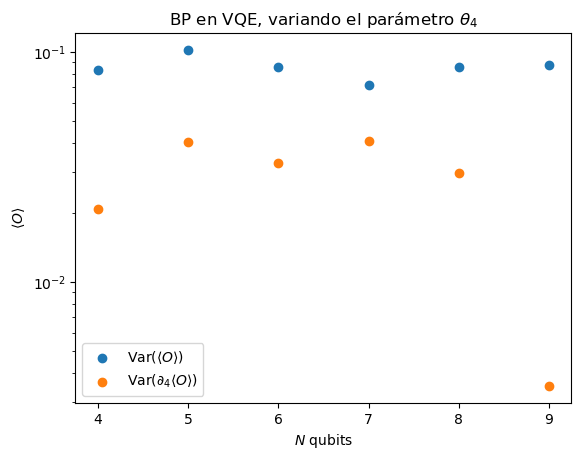

In [8]:
data = []

data.append(cf.variance_vs_nQubits(crear_ansatz_nlocal, 4, 9, hamiltonian, 4, 100, True, True))


Preparando ejecución para 4 qubits.
Se usarán 8 parámetros


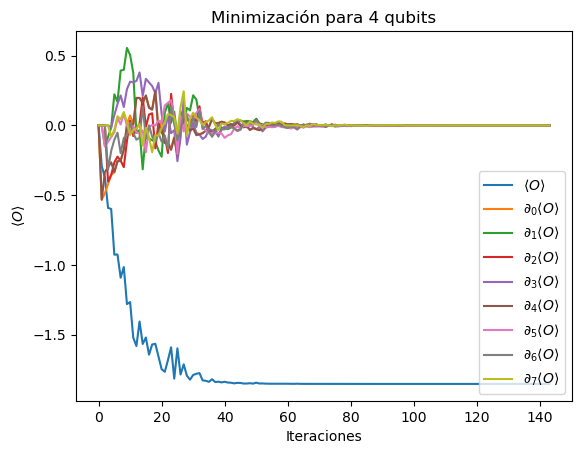

Fin ejecución con 4 qubits. Mínimo encontrado: -1.853709513157226

Preparando ejecución para 5 qubits.
Se usarán 10 parámetros


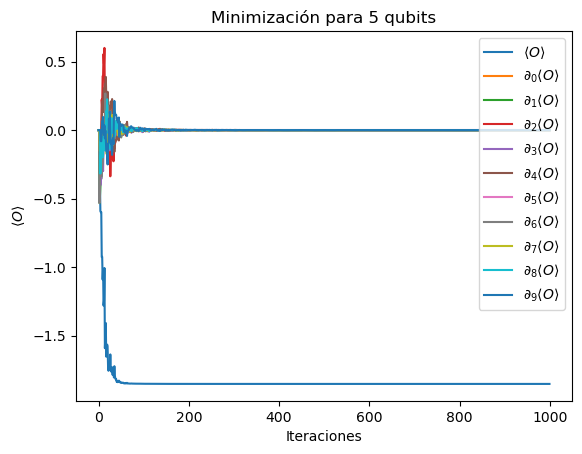

Fin ejecución con 5 qubits. Mínimo encontrado: -1.8537092714389733

Preparando ejecución para 6 qubits.
Se usarán 12 parámetros


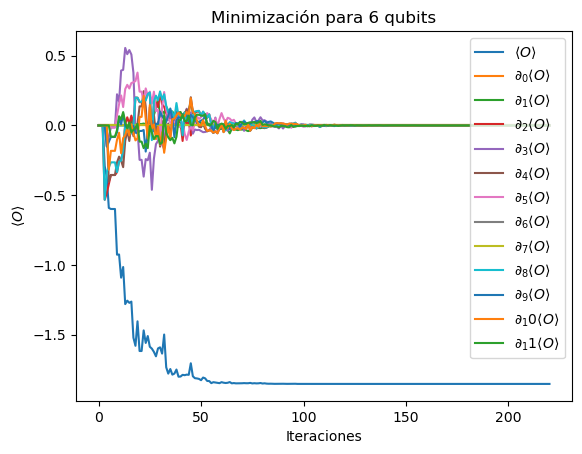

Fin ejecución con 6 qubits. Mínimo encontrado: -1.8537095140062123

Preparando ejecución para 7 qubits.
Se usarán 14 parámetros


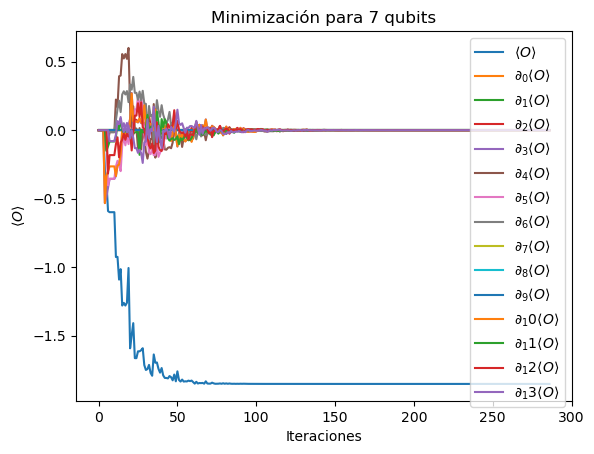

Fin ejecución con 7 qubits. Mínimo encontrado: -1.8537095133162826

Preparando ejecución para 8 qubits.
Se usarán 16 parámetros


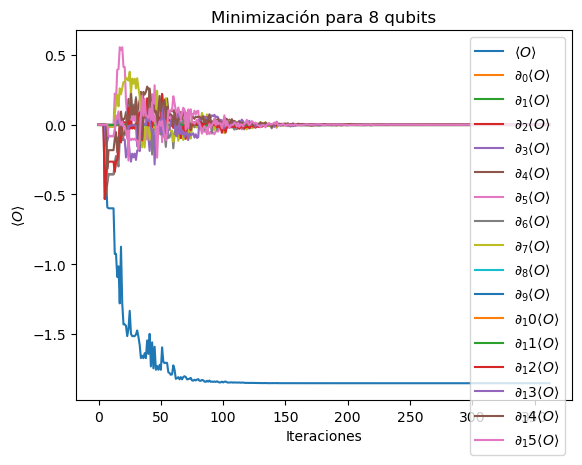

Fin ejecución con 8 qubits. Mínimo encontrado: -1.8537095142345688

Preparando ejecución para 9 qubits.
Se usarán 18 parámetros


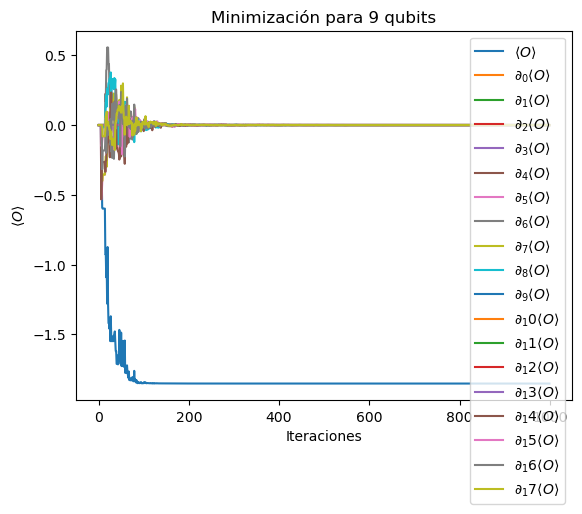

Fin ejecución con 9 qubits. Mínimo encontrado: -1.8537093546280634

Preparando ejecución para 10 qubits.
Se usarán 20 parámetros


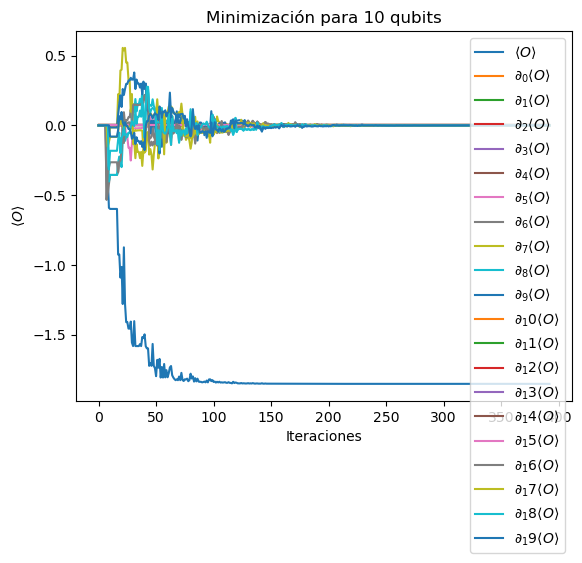

Fin ejecución con 10 qubits. Mínimo encontrado: -1.8537095150589558


In [5]:
cf.VQE_minimization_BP(crear_ansatz_nlocal, 4, 10, hamiltonian, "all")